# asd


### Notes

Physical effects to consider:
- Relative humidity is dependent on temperature (convert to specific humidity?)
- Cooling effect from evaporation inside fish tank?
- 

Questions:
- Why does specific humidity difference increase during the day?
  - Maybe because of different rate of evaporation?
  - Physical changes in plants during lighter hours?
  
          Wikipedia/Transpiration:
            The rate of transpiration is controlled by stomatal aperture, and these small pores open especially for photosynthesis. While there are exceptions to this (such as night or CAM photosynthesis), in general a light supply will encourage open stomata. 

Potential to-do:
- Transform relative humidity so that it has a linear relationship with temperature
- Get more accurate historical data on pressure to use in conversions (rather than just using 1000hPa)

In [180]:
import datetime

import numpy as np
import pandas as pd

import plotly.express as px
import seaborn as sns
sns.set_theme(style="darkgrid")



Use the DHT SQL python API to connect to the local replica server.

Query server and get DHT data

In [ ]:
from include.DHT_MySQL_interface import DHTConnection, ObsDHT

raspi_connection_config = {
    "host": '192.168.1.109',
    "database": "pi_humidity",
    "user": "haydeni0",
    "password": "raspizeroWH_SQL",
    'raise_on_warnings': True
}

HaydensPC_connection_config = {
    "host": 'localhost',
    "database": "pi_humidity",
    "user": "haydeni0",
    "password": "OSzP34,@H0.I2m$sZpI<",
    'raise_on_warnings': True
}

TABLE_NAME_inside = "dht_inside"
TABLE_NAME_outside = "dht_outside"

pi_humidity_SQL = DHTConnection(HaydensPC_connection_config)


In [ ]:
# What time interval to pull from the server
start_dtime = datetime.datetime(2021, 11, 1)
# end_dtime = datetime.datetime(2022, 1, 8)
end_dtime = datetime.datetime(2021, 12, 1)

dht_inside = pd.DataFrame(tuple(zip(*pi_humidity_SQL.getObservations(TABLE_NAME_inside, start_dtime, end_dtime))), columns=["dtime", "humidity_inside", "temperature_inside"])
dht_outside = pd.DataFrame(tuple(zip(*pi_humidity_SQL.getObservations(TABLE_NAME_outside, start_dtime, end_dtime))), columns=["dtime", "humidity_outside", "temperature_outside"])
# Merge (using primary key dtime) into a single dataframe
df_total = pd.merge(dht_inside, dht_outside)
# Set the dtime as the index
df_total.set_index(["dtime"], inplace=True)


In [177]:
import metpy.calc
import metpy.units

# Resample the data to remove errors (with median) and reduce the number of datapoints
df = df_total.resample("10min").median()

# Rescale relative humidity to have dimensionless units
df[["humidity_inside", "humidity_outside"]] = df[["humidity_inside", "humidity_outside"]]/100

# Make a version with units for metpy
df_units = metpy.units.pandas_dataframe_to_unit_arrays(df, {"humidity_inside": "", "humidity_outside": "", "temperature_inside": "degree_Celsius", "temperature_outside": "degree_Celsius"})
# Calculate specific humidity values using approximate 1000 hPa pressure value
p0 = metpy.units.units.Quantity(1_000_00, "pascal")
dewpoint_inside = metpy.calc.dewpoint_from_relative_humidity(df_units["temperature_inside"], df_units["humidity_inside"])
df["specific_humidity_inside"] =  metpy.calc.specific_humidity_from_dewpoint(p0, dewpoint_inside)
dewpoint_outside = metpy.calc.dewpoint_from_relative_humidity(df_units["temperature_outside"], df_units["humidity_outside"])
df["specific_humidity_outside"] =  metpy.calc.specific_humidity_from_dewpoint(p0, dewpoint_outside)

# Add extra transformed variables
df["humidity_diff"] = df["humidity_inside"] - df["humidity_outside"]
df["specific_humidity_diff"] = df["specific_humidity_inside"] - df["specific_humidity_outside"]
df["temperature_diff"] = df["temperature_inside"] - df["temperature_outside"]
df["ht_diff"] = df["humidity_diff"] - df["temperature_diff"]
df["sht_diff"] = df["specific_humidity_diff"] - df["temperature_diff"]


df

,humidity_inside,temperature_inside,humidity_outside,temperature_outside,specific_humidity_inside,specific_humidity_outside,humidity_diff,specific_humidity_diff,temperature_diff,ht_diff,sht_diff
dtime,,,,,,,,,,,
2021-11-01 00:00:00,0.825,20.7,0.592,20.1,0.012617,0.008704,0.233,0.003914,0.6,-0.367,-0.596086
2021-11-01 00:10:00,0.827,20.5,0.595,19.9,0.012492,0.008640,0.232,0.003852,0.6,-0.368,-0.596148
2021-11-01 00:20:00,0.831,20.4,0.598,19.8,0.012475,0.008630,0.233,0.003845,0.6,-0.367,-0.596155
2021-11-01 00:30:00,0.836,20.3,0.606,19.7,0.012473,0.008691,0.230,0.003781,0.6,-0.370,-0.596219
2021-11-01 00:40:00,0.840,20.2,0.611,19.6,0.012455,0.008709,0.229,0.003746,0.6,-0.371,-0.596254
...,...,...,...,...,...,...,...,...,...,...,...
2021-11-30 23:10:00,0.865,21.9,0.480,22.4,0.014254,0.008125,0.385,0.006130,-0.5,0.885,0.506130
2021-11-30 23:20:00,0.864,21.8,0.491,21.9,0.014150,0.008061,0.373,0.006089,-0.1,0.473,0.106089
2021-11-30 23:30:00,0.865,21.6,0.506,21.4,0.013993,0.008057,0.359,0.005936,0.2,0.159,-0.194064


# Plotting


#### Time series

In [179]:
# subset df for better viewing
df1 = df.loc[(datetime.datetime(2021,11,1) <= df.index) & (df.index < datetime.datetime(2021,11,7))]
# sns.lineplot(x="dtime", y="humidity_inside", data=df1)

# Rescale



# figh = px.line(df1, x=df1.index, y=["humidity_inside", "humidity_outside"])
# figh.show()
# figsh = px.line(df1, x=df1.index, y=["specific_humidity_inside", "specific_humidity_outside"])
# figsh.show()
# fighd = px.line(df1, x=df1.index, y="humidity_diff")
# fighd.show()
figshd = px.line(df1, x=df1.index, y="specific_humidity_diff")
figshd.show()

figt = px.line(df1, x=df1.index, y="temperature_diff")
figt.show()
# fightd = px.line(df1, x=df1.index, y="ht_diff")
# fightd.show()
# figshtd = px.line(df1, x=df1.index, y="sht_diff")
# figshtd.show()


In [ ]:
sns.lineplot(x="dtime", y="x1", hue="sensor", data=pd.melt(df1, var_name="sensor", value_name="value"))

#### Correlation, power spectral density

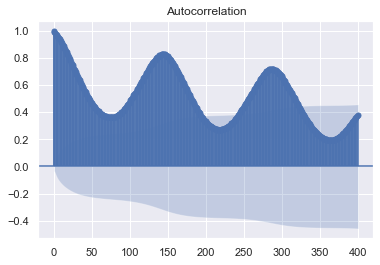

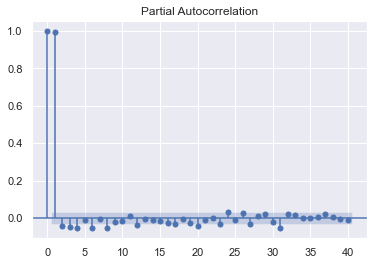

In [242]:
import scipy.signal
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import ccf

freq, psd = scipy.signal.periodogram(df["humidity_inside"])

# fig = px.line(x=freq*2*(24*60/10), y=psd, log_y=True, log_x=True, title="Power spectral density (PSD)", 
#               labels={
#                   "x": "Frequency (per day)"
#               })
# fig.show()

fig = plot_acf(df["specific_humidity_diff"], lags=400)
fig = plot_pacf(df["specific_humidity_diff"], lags=40)


xc = ccf(df["specific_humidity_diff"], df["temperature_diff"])
# xc_max_lag = 40
xc_max_lag = len(xc)
fig = px.line(x=range(xc_max_lag), y=xc[:xc_max_lag], title="Cross correlation", labels={"x": "lag"})
fig.show()

# Modelling

In [ ]:
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.stattools import grangercausalitytests

# Extra / testing

In [ ]:
# See units
import pint
ureg = pint.UnitRegistry()

ureg.get_compatible_units('[pressure]')